In [1]:
pip install ephem


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
from datetime import datetime, timedelta
import ephem
import math
import cmath
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import random

### Carpet's coordinates

In [3]:
longuitude = 42.684872 # Carpet
latitude = 43.273004 # Carpet
Phi = latitude*np.pi/180
sinB = np.sin(Phi)
cosB = np.cos(Phi)

### Reading data from Carpet (for 2018-2024)

In [4]:
class Carpet():
    def __init__(self):
        self.date = None
        self.RA  = None
        self.DEC = None
        self.Ne = None
        self.mu = None #n_mu
        self.b = None #galactic latitude
        self.theta = None #zenith angle
        self.phi = None #azimuth angle

def equ2ga(equ):
    '''
    Converts Equatorial to Galactic coordinates (J2000.0)
    Source: https://www.atnf.csiro.au/people/Tobias.Westmeier/tools_coords.php

    Parameters
    ----------
    [ra, dec] : array
        Right Ascension and Declination in decimal degrees
    
    Returns
    -------
    [l, b] : array
        Galactic longitude and galactic latitude in decimal degrees
    '''
    ra = np.radians(equ[0])
    dec = np.radians(equ[1])

    # North galactic pole (J2000) -- according to Wikipedia
    pole_ra = np.radians(192.7666)
    pole_dec = np.radians(27.13)
    posangle = np.radians(122.93314)

    l=posangle-np.arctan((np.cos(dec)*np.sin(ra-pole_ra))/(np.sin(dec)*np.cos(pole_dec)-np.cos(dec)*np.sin(pole_dec)*np.cos(ra-pole_ra)))
    b=np.arcsin(np.sin(dec)*np.sin(pole_dec)+np.cos(dec)*np.cos(pole_dec)*np.cos(ra-pole_ra))

    return np.array([np.degrees(l), np.degrees(b)])

def GetCarpetData(file, Photon=True):
    if file == '2024_001-102_n.txt': #for 2024 data we have different coloumns in file
        idx = 8 #index of coloumn with n_mu in different files
    else:
        idx = 7
    data = []
    fop = open(file)
    for line in fop.readlines():
        sl = line.split()
        if Photon: #Read only photon-like candidates
            if np.log10((float(sl[idx])+0.1)/float(sl[idx+9])) > -5.5: #float(sl[idx]) != 0:
                continue
        c = Carpet()
        year = '20' + sl[0]
        day = sl[1]
        day.rjust(3 + len(day), '0')
        d = datetime.strptime(year + "-" + day, "%Y-%j").strftime("%d.%m.%y")
        t = sl[3] + ':' + sl[4] + ':' + sl[5]
        dt = datetime.strptime(d + ' ' + t, '%d.%m.%y %H:%M:%S')
        c.date = dt
        c.RA = float(sl[idx+5])
        c.DEC = float(sl[idx+6])
        c.Ne = float(sl[idx+9])
        c.mu = float(sl[idx])
        lb = equ2ga([float(sl[idx+5]), float(sl[idx+6])])
        c.b = lb[1]
        c.phi = float(sl[idx+3])
        c.theta = float(sl[idx+4])
        data.append(c)
    fop.close()
    return data

def sidtime(date): #Sidereal time for AltAz coordinates
    y = date.year
    m = date.month
    d = date.day
    UTh = date.hour
    UTmin = date.minute
    UTsec = date.second
    d0 = 367*y - math.modf(7/4*(y + math.modf((m + 9)/12)[1] ))[1] + math.modf(275*m/9)[1] + d - 730531.5 + (UTh + UTmin/60. + UTsec/3600.)/24
    sdeg = math.fmod(280.46061837 + 360.98564736629*d0 + longuitude, 360)
    return sdeg #s in degrees

def equatorial(A, Z, s):
    '''
    Converting AltAz to Equatorial coordinates

    Parameters
    ----------
    A : float
        Altitude in degrees
    Z : float
        Azimuth in degrees
    s : float
        Sidereal time in radians

    Returns
    -------
    [ra, dec] : array
        Right Ascension and Declination in decimal degrees
    '''
    A = A * np.pi / 180 #converting to rad
    sinZ = math.sin(Z * np.pi / 180) #converting to rad
    sinA = math.sin(A)
    cosA = math.cos(A)
    cosZ = (1-sinZ**2)**0.5
    sinDelta = sinB*cosZ - cosB*sinZ*cosA  
    cosDelta = (1 - sinDelta**2)**0.5
    delta = math.asin(sinDelta)
    cosT = (cosZ*cosB + sinZ*sinB*cosA)/cosDelta
    if sinA > 0 :
       t = cmath.acos(cosT) #t in radians
    else : 
       t = (math.pi + cmath.acos(-cosT)) #t in radians
    alpha = (s - t).real; 
    Delta = 180.0*delta/math.pi 
    if alpha > 0 :
       Alpha = 180.0*alpha/math.pi
    else: 
       Alpha = 180*(alpha + 2*math.pi)/math.pi
    return [Alpha, Delta]

In [5]:
Photon = False
files = ['2018_097-357_n.txt', '2019_001-365_n.txt', '2020_001-366_n.txt', '2021_001-365_n.txt', '2022_001-365_n.txt', '2023_001-365_n.txt', '2024_001-102_n.txt']
carpet = []
for file in files:
      c = GetCarpetData(file, Photon)
      carpet += c

### Calculating Moon position at Carpet's event arrival time

In [7]:
def MoonPosition(carpet_data):
    '''
    Returns the azimuth and altitude of the Moon at the time of the Carpet event.

    Parameters
    ----------
    carpet_data : list
        List of Carpet events data. Each event should have datetime as an attribute (carpet_data.date).
    
    Returns
    -------
    moon_alt : float
        altitude of the Moon at the time of the Carpet event, deg

    moon_az : float
        azimuth of the Moon at the time of the Carpet event, deg
    '''
    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longuitude)
    observer.date = str(carpet_data.date)
    moon = ephem.Moon()
    moon.compute(observer)
    moon_alt=float(moon.alt)/np.pi*180
    moon_az=float(moon.az)/np.pi*180

    return moon_alt, moon_az #return in deg

### Calculating the angle between the object and the Carpet event

In [8]:
def Angle(carpet_data, alt, phi):
    '''
    Returns the angle between the object and the Carpet event azimuthal coordinates

    Parameters
    ----------
    carpet_data : list
        List of Carpet events data. Each event should have theta and phi as attributes (o.theta, o.phi)
    alt : float
        Altitude of the object (e.g. the Moon), deg
    phi : float
        Azimuth of the object (e.g. the Moon), deg

    Returns
    -------
    psi : float
        angle between the object and the Carpet event, deg
    '''
    s = sidtime(carpet_data.date)
    alpha_obj, delta_obj = equatorial(phi, 90-alt, s * np.pi /180) #returns RA and DEC of the Moon in degrees
    #converting to radians
    alpha_obj = alpha_obj * np.pi /180 
    delta_obj = delta_obj * np.pi /180
    alpha_c = carpet_data.RA * np.pi /180
    delta_c = carpet_data.DEC * np.pi /180
    #calculating the angle between the Moon and the Carpet event
    psi_rad=np.arccos(np.sin(delta_obj)*np.sin(delta_c) + np.cos(delta_obj)*np.cos(delta_c)*np.cos(alpha_obj-alpha_c))
    psi=psi_rad*180/np.pi
    return psi

In [9]:
#Calculating angles for real and fake (background) Moon 
#Fake Moons are calculated as real Moon azimuth ±18, ±24, ±30. Altitude stays the same
DA = []; DA_p18 = []; DA_m18 = []; DA_p24 = []; DA_m24 = []; DA_p30 = []; DA_m30 = []
m_alt = []; m_az = []
DA_p14 = []; DA_m14 = []; DA_p28 = []; DA_m28 = []
for carp in carpet:
    alt, az = MoonPosition(carp)
    m_alt.append(alt); m_az.append(az)
    psi = Angle(carp, alt, az)
    DA.append(psi)
    '''
    DA_p18.append(Angle(carp, alt, az+18))
    DA_m18.append(Angle(carp, alt, az-18))
    DA_p24.append(Angle(carp, alt, az+24))
    DA_m24.append(Angle(carp, alt, az-24))
    DA_p30.append(Angle(carp, alt, az+30))
    DA_m30.append(Angle(carp, alt, az-30))
    '''
    DA_p14.append(Angle(carp, alt, az+14))
    DA_m14.append(Angle(carp, alt, az-14))
    DA_p28.append(Angle(carp, alt, az+28))
    DA_m28.append(Angle(carp, alt, az-28))

### Calculating the number of events in each bin

In [10]:
def Binning(DA):
    '''
    Returns the number of events in each bin

    Parameters
    ----------
    DA : list
        List of angles between the object and the Carpet event

    Returns
    -------
    N : array
        2D array of the number of events in each bin
    N_omega : array
        2D array of the density of events in each bin
    '''
    bins = list(np.arange(0, 15*0.5, 0.5)) #bins from 0 to 15 deg with step 1 deg
    angles = []
    for i in range(len(bins)-1):
        a = []
        for angle in DA:
            if bins[i] <= abs(angle) < bins[i+1]: #assigning event angles to the bins
                a.append(angle)
        angles.append(a)

    psi_0=0.5 #step size, deg
    omega = []
    omega_0 = np.pi * (psi_0)**2 #area of the circle
    omega.append(omega_0)

    # Calculating N (the the number of events in each bin)
    N = [] 
    for i in range(len(angles)):
        N.append(len(angles[i]))

    # Calculating omega (the area of the annulus)
    for i in range(len(bins)-2):
        omega.append(np.pi*(bins[i+2]**2 - bins[i+1]**2)) #area of the annulus
    
    # Calculating N_omega (the event density in each bin) as N/omega*omega_0
    N_omega = [] 
    for i in range(len(omega)):
        N_omega.append(N[i]/omega[i]*omega_0)

    return N, N_omega

In [11]:
N, N_omega = Binning(DA)
'''
N_m18, N_omega_m18 = Binning(DA_m18)
N_m24, N_omega_m24 = Binning(DA_m24)
N_m30, N_omega_m30 = Binning(DA_m30)
N_p18, N_omega_p18 = Binning(DA_p18)
N_p24, N_omega_p24 = Binning(DA_p24)
N_p30, N_omega_p30 = Binning(DA_p30)
'''
N_p14, N_omega_p14 = Binning(DA_p14)
N_m14, N_omega_m14 = Binning(DA_m14)
N_p28, N_omega_p28 = Binning(DA_p28)
N_m28, N_omega_m28 = Binning(DA_m28)

In [12]:
#Calculating deficit of cosmic rays from the direction of the Moon relative to the background
n = 4 #6
rel_dif = [] #
sigma = []
for i in range(len(N)):
    #Mean of each bin for fake (background) moons
    #N_f_mean = (N_m18[i]+N_m24[i]+N_m30[i]+N_p18[i]+N_p24[i]+N_p30[i])/n
    N_f_mean = (N_m14[i]+N_m28[i]+N_p14[i]+N_p28[i])/n

    #Deficit
    rel_dif.append((N[i]-N_f_mean)/N_f_mean * 100)

    #Uncertainty
    sigma.append((N[i]/N_f_mean * np.sqrt(1/N[i] + 1/n/N_f_mean)*100))

### Fitting data to find the angular resolution

In [13]:
def Model_Gaussian(psi, sigma_psi):
    '''
    Returns the model of the Gaussian function

    Parameters
    ----------
    psi : array, deg
        Array of angles between the Moon and the Carpet event
    sigma_psi : float, deg
        Carpet resolution

    Returns
    -------
    result : array
        Deficit of cosmic rays (delta N / N_background)
    '''
    psi_moon = 0.26 #Moon angular radius
    result = -(psi_moon**2)/(2*sigma_psi**2) * np.exp(-(psi**2)/(2*sigma_psi**2))
    return result*100

space_ang = np.arange(0.5, 15*0.5, 0.5)
popt, pcov = curve_fit(Model_Gaussian, space_ang, rel_dif)
print(popt)

[0.99458846]


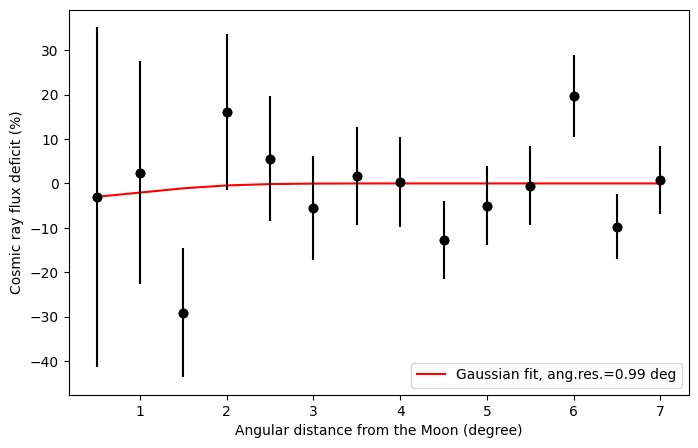

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax.set_xlabel('Angular distance from the Moon (degree)')
ax.set_ylabel('Cosmic ray flux deficit (%)')
ax.plot(space_ang, rel_dif, 'ko')
ax.plot(space_ang, Model_Gaussian(space_ang, popt), '-r', label = 'Gaussian fit, ang.res.='+str(round(popt[0],2))+' deg')
plt.errorbar(space_ang, rel_dif, yerr = sigma, fmt = 'o', color = 'k')
plt.legend(loc='lower right')
plt.show()

### Plotting the distribution of Carpet events

In [15]:
alpha_m = []
delta_m = []
for i in range(len(m_alt)):
    s = sidtime(carpet[i].date)
    alpha_obj, delta_obj = equatorial(m_az[i], 90-m_alt[i], s * np.pi /180)
    alpha_m.append(alpha_obj)
    delta_m.append(delta_obj)
alpha_c = [o.RA for o in carpet]
delta_c = [o.DEC for o in carpet]

Ddelta = []; Dalpha = []
for i in range(len(delta_c)):
    Ddelta.append(delta_c[i] - delta_m[i])
    Dalpha.append(alpha_c[i] - alpha_m[i])

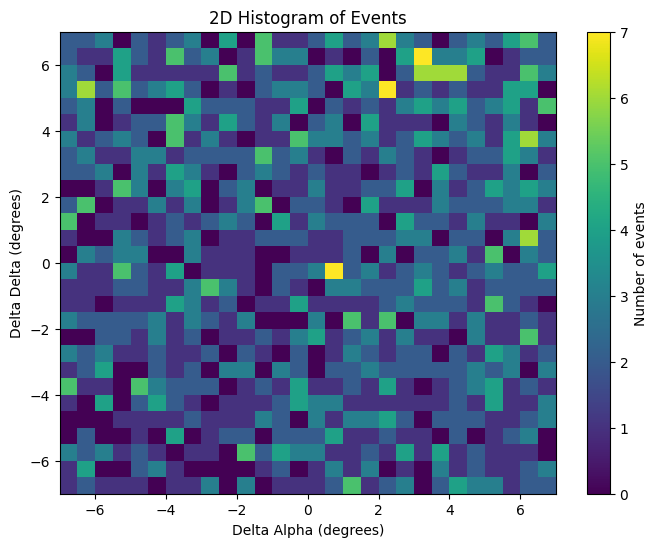

In [16]:
# Number of bins (140 x 140)
num_bins = 28

# Define the bin edges (from -7 to 7) with 140 bins
bin_edges = np.linspace(-7, 7, num_bins + 1)

# Filter Dalpha and Ddelta together based on the 7.5 deg limit
filtered_data = [(da, dd) for da, dd in zip(Dalpha, Ddelta) if abs(da) < 7.5 and abs(dd) < 7.5]

# Separate filtered data back into Dalpha_new and Ddelta_new
Dalpha_new, Ddelta_new = zip(*filtered_data)

# Convert them back to numpy arrays (if needed)
Dalpha_new = np.array(Dalpha_new)
Ddelta_new = np.array(Ddelta_new)

data, xedges, yedges = np.histogram2d(Dalpha_new, Ddelta_new, bins=[bin_edges, bin_edges])

# Create the plot
plt.figure(figsize=(8, 6))
plt.pcolormesh(xedges, yedges, data.T, cmap='viridis', shading='auto')
plt.colorbar(label='Number of events')

# Set labels and title
plt.xlabel('Delta Alpha (degrees)')
plt.ylabel('Delta Delta (degrees)')
plt.title('2D Histogram of Events')

# Show the plot
plt.show()

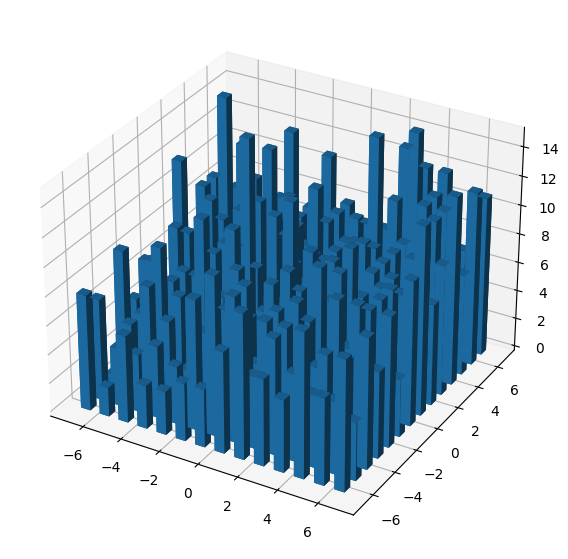

In [17]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(Dalpha, Ddelta, bins=14, range=[[-7, 7], [-7, 7]])
# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

### MC simulation

In [ ]:
def shuffleCarpet(carpet_data):
    #Create MC data according to S.Troitsky
    """
    Из каталога фотонных кандидатов берутся случайным образом зенитный угол от одного события
    и азимутальный угол от другого события. Приписывается случайное время прихода (звездное время,
    равномерное распределение от 0 до 24 ч). Восстанавливаются экваториальные координаты 
    случайного события(RA, DEC). Таким образом, составляется каталог случайных событий той же 
    длины, что реальное число фотонных кандидатов в данных.
    """
    zenith = [o.theta for o in carpet_data]
    azimuth = [o.phi for o in carpet_data]
    data = []
    for carp in carpet_data:
        c = Carpet()
        c.theta = random.choice(zenith)
        c.phi = random.choice(azimuth)
        c.date = carp.date + timedelta(hours=random.uniform(0, 24)) 
        stime = sidtime(c.date) * np.pi / 180
        alphadelta = equatorial(c.phi, c.theta, stime*np.pi/180)
        c.RA = alphadelta[0]
        c.DEC = alphadelta[1]
        c.Ne = carp.Ne
        c.mu = carp.mu
        lb = equ2ga([c.RA, c.DEC])
        c.b = lb[1]
        data.append(c)
    return data

[0.98034241]
[-4.95848888]
[0.37610687]
[1.29679002]
[0.35286594]
[-0.35828808]
[-0.35873099]
[0.80021164]
[0.77271935]
[0.4633115]
[-0.35204858]
[1.14251207]
[-0.76230074]
[3.24970512]
[-0.3746528]
[1.75290502]
[-0.50772669]
[-0.35071041]
[1.5084171]
[0.34263062]
[-0.37745729]
[1.56274955]
[0.35259318]
[-0.41373029]
[1.09289858]
[-0.44461283]
[0.83022017]
[-0.38421334]
[-0.45050716]
[-2.01204887]
[-0.34344524]
[0.35498134]
[-0.36421537]
[-2.38675105]
[0.36487857]
[-0.52571182]
[-0.36050573]
[0.35005012]
[1.13756628]
[-0.43249999]
[0.37565802]
[0.80890435]
[-0.45045259]
[-4.03364811]
[-0.4164687]
[0.34182735]
[0.43871803]
[-1.87444724]
[2.55307552]
[-4.61428799]
[-0.36071317]
[0.68714985]
[-2.06067813]
[-0.33664782]
[1.86788729]
[0.54404959]
[-4.32618524]
[2.30454038]
[-0.51620734]
[1.47565257]
[1.89977847]
[-0.49049343]
[-0.4205187]
[4.21713391]
[3.52446408]
[0.74173853]
[-1.904112]
[-2.78920673]
[-0.51619546]
[0.33252823]
[-2.10062717]
[0.46305199]
[-0.43102091]
[1.36672413]
[-0.3753

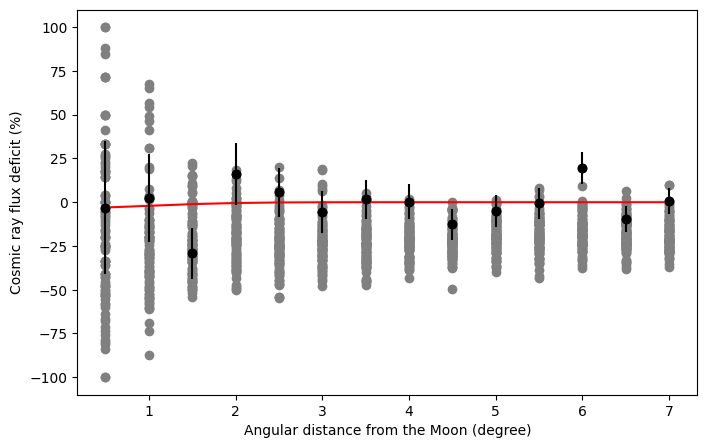

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
ax.set_xlabel('Angular distance from the Moon (degree)')
ax.set_ylabel('Cosmic ray flux deficit (%)')
ax.plot(space_ang, rel_dif, 'ko')
ax.plot(space_ang, Model_Gaussian(space_ang, popt), '-r', label = 'Gaussian fit, ang.res.='+str(round(popt[0],2))+' deg')
plt.errorbar(space_ang, rel_dif, yerr = sigma, fmt = 'o', color = 'k')

N_SIM = 100
for i in range(N_SIM):
    carpetMC = shuffleCarpet(carpet)
    DA = []; DA_p14 = []; DA_m14 = []; DA_p28 = []; DA_m28 = []
    m_alt = []; m_az = []
    for carp in carpetMC:
        alt, az = MoonPosition(carp)
        m_alt.append(alt); m_az.append(az)
        psi = Angle(carp, alt, az)
        DA.append(psi)
        DA_p14.append(Angle(carp, alt, az+14))
        DA_m14.append(Angle(carp, alt, az-14))
        DA_p28.append(Angle(carp, alt, az+28))
        DA_m28.append(Angle(carp, alt, az-28))

    N, N_omega = Binning(DA)
    N_p14, N_omega_p14 = Binning(DA_p14)
    N_m14, N_omega_m14 = Binning(DA_m14)
    N_p28, N_omega_p28 = Binning(DA_p28)
    N_m28, N_omega_m28 = Binning(DA_m28)

    #Calculating deficit of cosmic rays from the direction of the Moon relative to the background
    n = 4 #6
    rel_dif = [] 
    sigma = []
    for i in range(len(N)):
        #Mean of each bin for fake (background) moons
        N_f_mean = (N_m14[i]+N_m28[i]+N_p14[i]+N_p28[i])/n

        #Deficit
        rel_dif.append((N[i]-N_f_mean)/N_f_mean * 100)

        #Uncertainty
        if N[i] == 0:
            sigma.append(0)
        else:
            sigma.append((N[i]/N_f_mean * np.sqrt(1/N[i] + 1/n/N_f_mean)*100))

    space_ang = np.arange(0.5, 15*0.5, 0.5)
    popt, pcov = curve_fit(Model_Gaussian, space_ang, rel_dif)
    print(popt)

    plt.scatter(space_ang, rel_dif, color='gray', marker='o')
    #plt.errorbar(space_ang, rel_dif, yerr = sigma, fmt = 'o', color = 'gray')

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1254ab87-4196-482f-af78-a01d8f0f49a1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>